# Exploring the solution object

ODE filters are probabilistic numerical algorithms, which means they compute probability distributions over possible solutions instead of simple point estimates.
A probabilistic description is much richer than a non-probabilistic description, so the solution objects returned by the ODE filter are a lot of fun.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from odefilter import ivpsolve, recipes

backend.select("jax")  # ivp examples in jax


config.update("jax_enable_x64", True)

In [2]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.sir()


@jax.jit
def vector_field(y, *, t, p):
    return f(y, *p)


# Make a solver
solver, info_op = recipes.ekf1(ode_dimension=3, num_derivatives=2)

In [3]:
%%time
solution = ivpsolve.solve(
    vector_field,
    initial_values=(u0,),
    t0=t0,
    t1=t1,
    solver=solver,
    info_op=info_op,
    parameters=f_args,
    atol=1e-1,
    rtol=1e-1,
)

CPU times: user 1.99 s, sys: 20.3 ms, total: 2.01 s
Wall time: 1.95 s


We can access elements of the solution.

In [4]:
print(len(solution))
print(solution[-1])

39
Solution(t=DeviceArray(200., dtype=float64, weak_type=True), t_previous=DeviceArray(200., dtype=float64, weak_type=True), u=DeviceArray([5.91505901e+01, 2.00233991e-03, 9.38908503e+02], dtype=float64), output_scale_sqrtm=DeviceArray(0.3179044, dtype=float64, weak_type=True), marginals=MultivariateNormal(mean=DeviceArray([ 5.91505901e+01, -1.85340555e-05,  5.78423344e-06,
              2.00233991e-03, -6.70813834e-05,  3.01607433e-05,
              9.38908503e+02,  1.04241028e-04, -3.25308784e-05],            dtype=float64), cov_sqrtm_lower=DeviceArray([[-1.18919503e+01,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
             [ 1.41476046e-01, -3.50502534e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
             [ 2.55654246e-02, -6.54082904e-01,  1.39856824

We can plot an estimate of the solution.

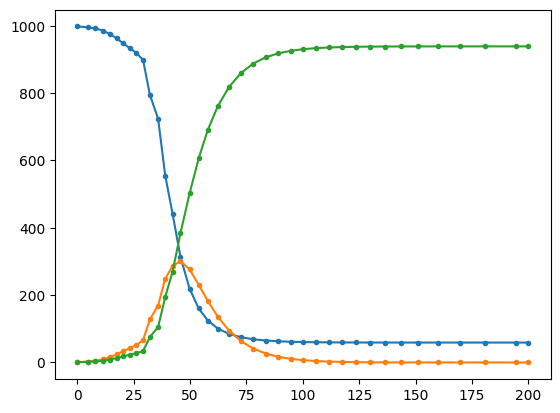

In [5]:
plt.plot(solution.t, solution.u, ".-")
plt.show()

But we can also look at the underlying distribution.
For starters, maybe we want to compute the marginal distribution over the solution away from
the grid points. This is similar to dense output, but waaaay cooler: there is not _one_ way of dense output with
probabilistic solvers, but there are

* marginals on off-grid points (most similar to traditional dense output)
* joint distributions on grid points and away from the grid points
* joint samples from the posterior

and many more options.
Look at this:

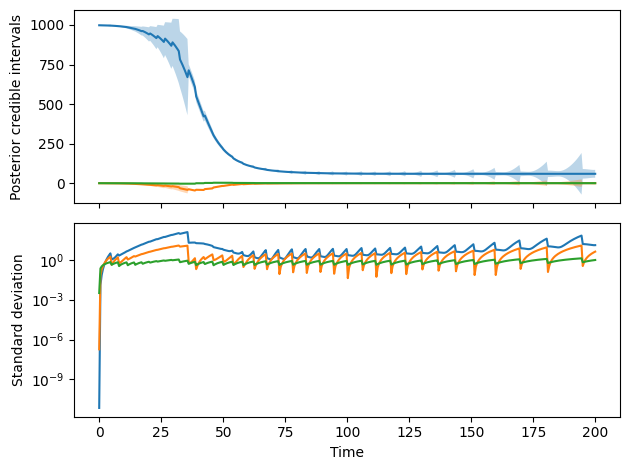

In [6]:
ts = jnp.linspace(t0 + 1e-4, t1 - 1e-3, num=400, endpoint=True)
_, dense = solver.offgrid_marginals_searchsorted(ts=ts, solution=solution)

fig, ax = plt.subplots(nrows=2, sharex=True, tight_layout=True)

for i in [0, 1, 2]:  # ["S", "I", "R"]
    ms = dense.mean[:, i]
    ls = dense.cov_sqrtm_lower[:, i, :]
    stds = jnp.sqrt(jnp.einsum("jn,jn->j", ls, ls))

    ax[0].plot(ts, ms)
    ax[0].fill_between(ts, ms - 1.96 * stds, ms + 1.96 * stds, alpha=0.3)
    ax[0].set_ylabel("Posterior credible intervals")

    ax[1].semilogy(ts, stds)
    ax[1].set_ylabel("Standard deviation")

ax[1].set_xlabel("Time")
plt.show()

Stay tuned for more.